In [43]:
import pandas as pd
import numpy as np

In [44]:
from baseline_model.load_data import load_data

In [64]:
df = load_data(True)
df.columns

Index(['race_date', 'track_id', 'race_number', 'race_type', 'distance_id',
       'distance_unit', 'surface', 'course_type', 'track_condition', 'weather',
       'track_sealed_indicator', 'registration_number', 'medication',
       'equipment', 'weight_carried', 'horse_weight', 'official_position',
       'length_behind_at_finish', 'jockey_id', 'trainer_id', 'owner_id',
       'trouble_indicator', 'scratch_indicator', 'scratch_reason',
       'short_comment', 'long_comment', 'horse_name', 'sex', 'age'],
      dtype='object')

In [65]:
df['medication'].value_counts()

L      683
       317
Name: medication, dtype: int64

In [53]:
df['dnf'] = np.where(
    (df['trouble_indicator'] == 'Y') | (df['length_behind_at_finish'] == 9999),
    1,
    0
)

df['scratched'] = np.where(
    df['scratch_indicator'] == 'Y',
    1,
    0
)

In [57]:
df['race_date'] = pd.to_datetime(df['race_date'])
df = df.sort_values(by=['registration_number', 'race_date'])

df['previous_race_date'] = df.groupby('registration_number')['race_date'].shift(1)
df['previous_race_dnf'] = df.groupby('registration_number')['dnf'].shift(1)
df['previous_race_scratch'] = df.groupby('registration_number')['scratched'].shift(1)
#df['previous_race_distance'] = df.groupby('registration_number')['race_distance'].shift(1)
df['previous_surface'] = df.groupby('registration_number')['surface'].shift(1)
df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days


#df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
#df['distance_jump'] = np.where(
#    df['distance_delta'] > 2,
#    1,
#    0
#)

df['rest_after_dnf'] = np.where(
    df['previous_race_dnf'] == 1,
    df['days_since_last_race'],
    None
)

df['rest_after_scratch'] = np.where(
    df['previous_race_scratch'] == 1,
    df['days_since_last_race'],
    None
)

df['surface_change'] = np.where(
    df['surface'] != df['previous_surface'],
    1,
    0
)

# maybe should account for covid
df['long_layoff'] = np.where(
    df['days_since_last_race'] > 365,
    1,
    0
)

df['lasix'] = np.where(
    'L' in df['medication'],
    1,
    0
)

#first_long = df[df['race_distance'] > 8].sort_values(by=['race_date']).groupby(['registration_number', 'trainer_registration_number', 'trainer_last_name', 'trainer_first_name']).first().reset_index()


In [61]:
trainers = df.groupby(['trainer_id']).agg({
    'race_number': 'count',
    'registration_number': 'nunique',
    'scratched': 'sum',
    'dnf': 'sum',
    'age': 'min',
    'lasix': 'sum',
    'days_since_last_race': ['min', 'median'],
    'rest_after_dnf': 'median',
    'rest_after_scratch': 'median',
    #'distance_jump': 'sum',
    'surface_change': 'sum',
    'long_layoff': 'sum',
}).reset_index()

trainers.columns = ['trainer_id',
'n_entries', 'unique_horses', 'scratched', 'dnf', 'min_age', 'lasix', 'days_since_last_race_min', 'days_since_last_race_median', 
'rest_after_dnf_median', 'rest_after_scratch_median', 'surface_changes', 'long_layoffs',

]

trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']
trainers['lasix_pct'] = trainers['lasix'] / trainers['n_entries']

#trainer_first_long = first_long.groupby(['trainer_id']).agg({
#    'age': 'median'
#}).reset_index().rename(columns={'age': 'first_long_age'})

#trainers = trainers.merge(trainer_first_long, on=['trainer_registration_number', 'trainer_last_name', 'trainer_first_name'], how='left')

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


In [62]:
trainers.head(2)

,trainer_id,n_entries,unique_horses,scratched,dnf,min_age,days_since_last_race_min,days_since_last_race_median,rest_after_dnf_median,rest_after_scratch_median,surface_changes,long_layoffs,scratches_per_entry,dnf_per_entry
0,4525,2,2,0,0,6.068493,NaN,NaN,NaN,NaN,2,0,0.0,0.0
1,6225,2,2,0,0,3.906849,NaN,NaN,NaN,NaN,2,0,0.0,0.0


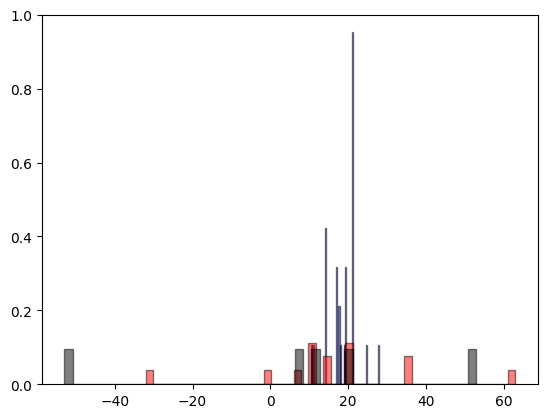

In [63]:
plt.hist(trainers['days_since_last_race_median'], color='blue', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.hist(trainers['rest_after_scratch_median'], color='red', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.hist(trainers['rest_after_dnf_median'], color='black', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.show()

# TODOs


## Baseline Model
- inference step
- lambda


## Risk Model
- preprocess
    - distance
    - beyer
    - medication
    - xRisk
    - parameterizes
    - previous target

- workouts


- target
    - dnf
    - badly beaten
    - likely injury (long layoff)
    
- Date loop




In [63]:

df['previous_performance_figure'] = df.groupby('registration_number')['performance_figure'].shift(1)
df['performance_figure'] = df['performance_figure'].str.replace('-', '0').astype(float, errors='ignore')
df['previous_performance_figure'] = df['previous_performance_figure'].str.replace('-', '0').astype(float, errors='ignore')

prev_perf = df.dropna(subset=['previous_performance_figure', 'performance_figure'])
prev_perf = prev_perf[(prev_perf['previous_performance_figure']) > 0 & (prev_perf['performance_figure'] > 0)]
prev_perf['performance_figure_ratio'] = prev_perf['performance_figure'] / prev_perf['previous_performance_figure']


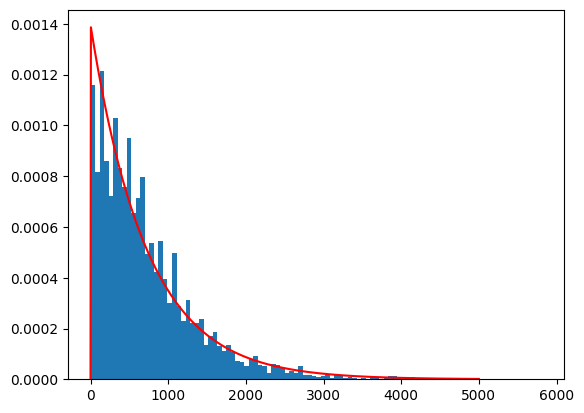

In [12]:
finished_racers = [d for d in df['length_behind_at_finish'] if (d < 9000 and d > 0)]
# fit exponential distribution
from scipy.stats import expon
import numpy as np
import matplotlib.pyplot as plt

data = finished_racers
loc, scale = expon.fit(data)
x = np.linspace(0, 5000, 1000)
y = expon.pdf(x, loc, scale)
plt.hist(data, bins=100, density=True)
plt.plot(x, y, 'r')
plt.show()

In [14]:
# get 95th percentile
badly_beaten_threshold = expon.ppf(0.95, loc, scale)

In [16]:
df['length_behind_at_finish'].max()

9999

In [17]:
df['scratch'] = np.where(
    df['scratch_indicator'] == 'Y',
    1,
    0
)

df['dnf'] = np.where(
    df['length_behind_at_finish'] == 9999,
    1,
    0
)

df['badly_beaten'] = np.where(
    (df['length_behind_at_finish'] > badly_beaten_threshold) & (df['length_behind_at_finish'] < 9000),
    1,
    0
)

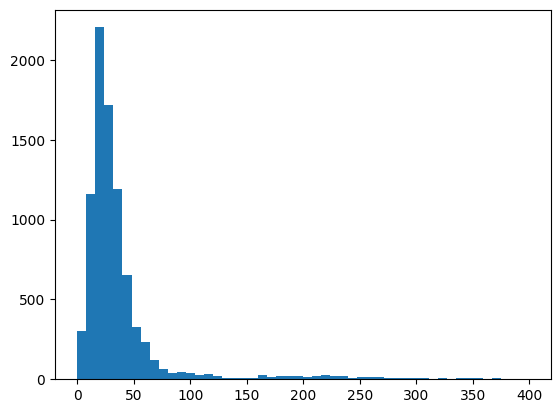

In [32]:
plt.hist([d for d in df['days_since_last_race'] if d < 400], bins=50)
plt.show()

/Users/jameshull/Documents/GitHub/hisa-trainer-injury/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/jameshull/Documents/GitHub/hisa-trainer-injury/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


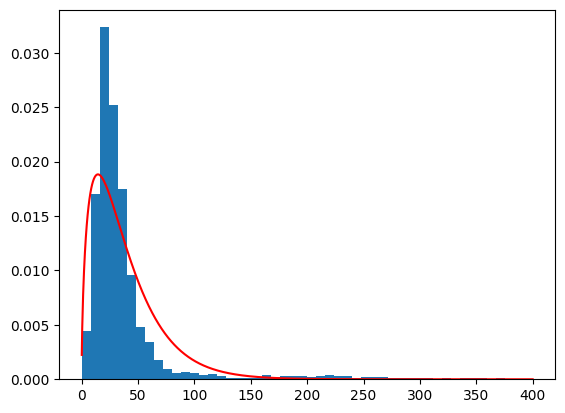

In [37]:
# fit negative binomial distribution
from scipy.stats import beta

# plot negative binomial distribution over data
import numpy as np
import matplotlib.pyplot as plt

data = [d for d in df['days_since_last_race'] if d < 400]

params = beta.fit(data)

x = np.linspace(0, 400, 1000)
y = beta.pdf(x, *params)
plt.hist(data, bins=50, density=True)
plt.plot(x, y, 'r')
plt.show()


In [9]:
# TODO CHECK
def fit_nbd(grouped_df: pd.DataFrame) -> pd.Series:
    
    params = nbinom.fit(grouped_df['days_since_last_race']).params

    return pd.Series(params, index=['n', 'loc', 'p'])

trainer_params = df.groupby('trainer_name').apply(fit_nbd)



NameError: name 'pd' is not defined

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters for the negative binomial distribution
n_true = 5    # number of successes
p_true = 0.3  # probability of success in each trial

# Generate sample data
data = np.random.negative_binomial(n_true, p_true, 1000)

# Fit the negative binomial distribution to the data
params = stats.nbinom.fit(data, floc=0)  # Fix location parameter at 0 for standard negative binomial

# Extract the parameters
n_est, loc_est, p_est = params
print(f"Estimated n: {n_est}")
print(f"Estimated p: {p_est}")

# Plot the histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Plot the PMF of the fitted negative binomial distribution
x = np.arange(0, max(data))
pmf_fitted = stats.nbinom.pmf(x, n_est, p_est)
plt.plot(x, pmf_fitted, 'r-', label='Fitted nbinom PMF')

plt.xlabel('Number of Failures')
plt.ylabel('Probability')
plt.legend()
plt.show()

# Perform the Kolmogorov-Smirnov test
ks_stat, p_value = stats.kstest(data, 'nbinom', args=(n_est, loc_est, p_est))
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")


AttributeError: 'nbinom_gen' object has no attribute 'fit'

In [1]:
# baseline testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from baseline_model.load_data import load_data
from baseline_model.preprocessing import preprocess_data

In [3]:
df = load_data(True)
df = preprocess_data(df)
df = df.drop(columns=['dnf', 'registration_number'])

In [4]:
with open('output/models/baseline_log_reg_model.pkl', 'rb') as f:
    log_reg_model = pickle.load(f)

with open('output/models/baseline_xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

XGBoostError: [19:08:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/include/xgboost/json.h:79: Invalid cast, from Array to Object
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000124ce7705 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000124ce41b0 xgboost::JsonObject const* xgboost::Cast<xgboost::JsonObject const, xgboost::Value>(xgboost::Value*) + 480
  [bt] (2) 3   libxgboost.dylib                    0x0000000124d9f5f0 xgboost::gbm::GBTree::LoadConfig(xgboost::Json const&) + 2096
  [bt] (3) 4   libxgboost.dylib                    0x0000000124dc0a66 xgboost::LearnerConfiguration::LoadConfig(xgboost::Json const&) + 774
  [bt] (4) 5   libxgboost.dylib                    0x0000000124dc2207 xgboost::LearnerIO::Load(dmlc::Stream*) + 1287
  [bt] (5) 6   libxgboost.dylib                    0x0000000124cf28dd XGBoosterUnserializeFromBuffer + 141
  [bt] (6) 7   libffi.6.dylib                      0x000000010cedb884 ffi_call_unix64 + 76
  [bt] (7) 8   ???                                 0x00007ffee3d0cfd0 0x0 + 140732720533456



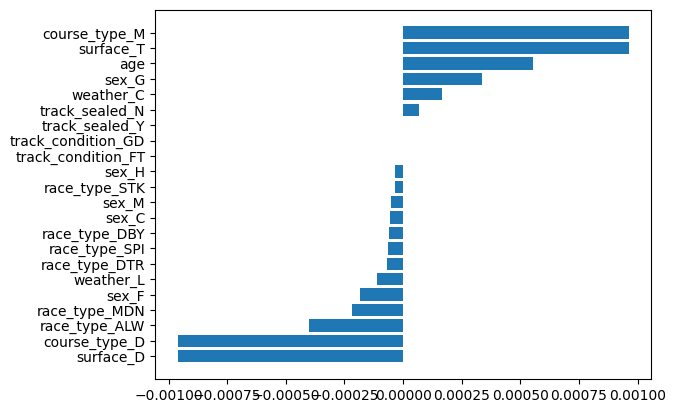

In [21]:
ft_imp = []
for col, coef in zip(log_reg_model.feature_names_in_, log_reg_model.coef_[0]):
    ft_imp.append({
        'feature': col,
        'importance': coef
    })

ft_imp = pd.DataFrame(ft_imp)
ft_imp = ft_imp.sort_values(by='importance')

plt.barh(ft_imp['feature'], ft_imp['importance'])
plt.show()


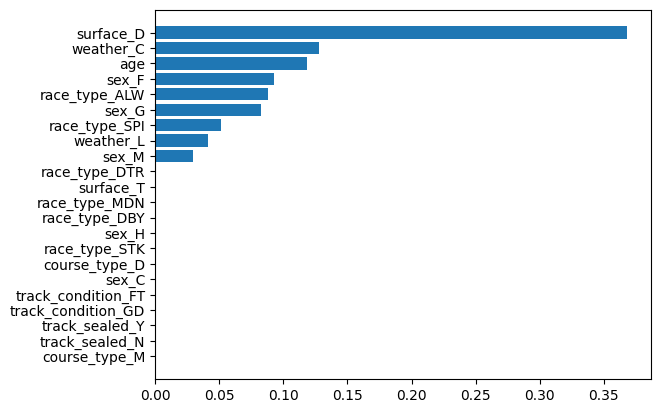

In [23]:
ft_imp = []
for col, coef in zip(xgb_model.feature_names_in_, xgb_model.feature_importances_):
    ft_imp.append({
        'feature': col,
        'importance': coef
    })

ft_imp = pd.DataFrame(ft_imp)
ft_imp = ft_imp.sort_values(by='importance')

plt.barh(ft_imp['feature'], ft_imp['importance'])
plt.show()

In [39]:
# use shap to get feature importance
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(df[xgb_model.feature_names_in_])



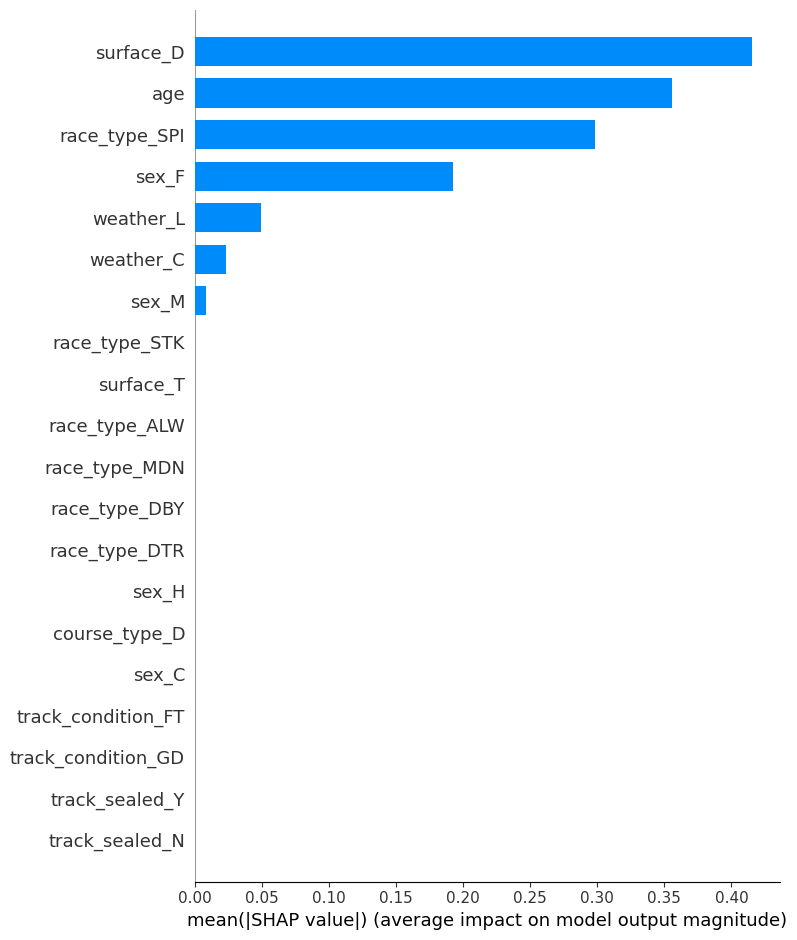

In [41]:
# plot the SHAP values
shap.summary_plot(shap_values, df[xgb_model.feature_names_in_], plot_type='bar')

In [29]:
# plot the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], df[xgb_model.feature_names_in_].iloc[0,:])


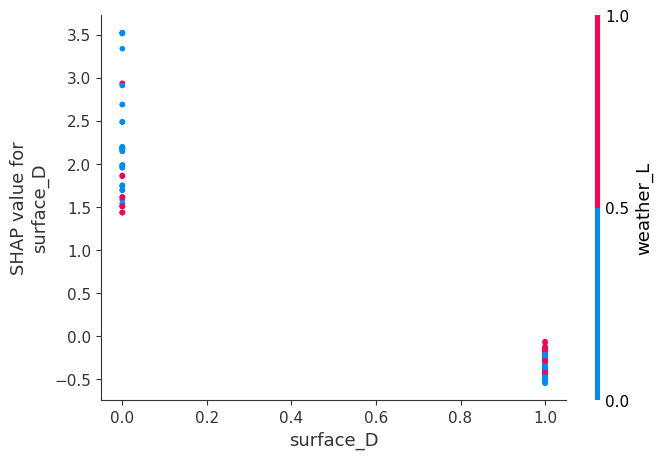

In [31]:
# plot shap for two features
shap.dependence_plot('surface_D', shap_values, df[xgb_model.feature_names_in_])